In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys

from aux import get_seg, mv_avg
from disp import set_font_size, get_line, set_color
from time_stats import xcov_multi_with_confidence

cc = np.concatenate

SONG_FILE = 'data/simple/c_songs.npy'
COLORS = [(.7, .7, .7), 'b', 'r', (1, .5, 0)]

In [2]:
tmp = np.load(SONG_FILE, allow_pickle=True)[0]
songs = tmp['songs']
dt = tmp['dt']
fps = tmp['fps']
ntr = len(songs)

In [3]:
durs = dt*np.array([len(s) for s in songs])
m_cpln = ~(durs == durs.max())

In [4]:
def plot_s(ax, t, s, extent, c, t_bar=1):
    """
    Note: extent: [x_min, x_max, y_min, y_max]
    """
    x_0 = extent[0]
    dx = (extent[1] - extent[0]) / len(s)
    modes = range(4)
    for mode in modes:
        bds = get_seg(s==mode, min_gap=1)[1]
        for istart, iend in bds:
            ax.fill_between([x_0+dx*istart, x_0+dx*iend], 2*[extent[2]], 2*[extent[3]], color=c[mode])
            
    dt = np.mean(np.gradient(t))
    dy_scale = .2*(extent[3]-extent[2])
    ax.fill_between([x_0, x_0+dx/dt*t_bar], 2*[extent[3] + 2*dy_scale], 2*[extent[3] + 3*dy_scale], color='k')
    return ax

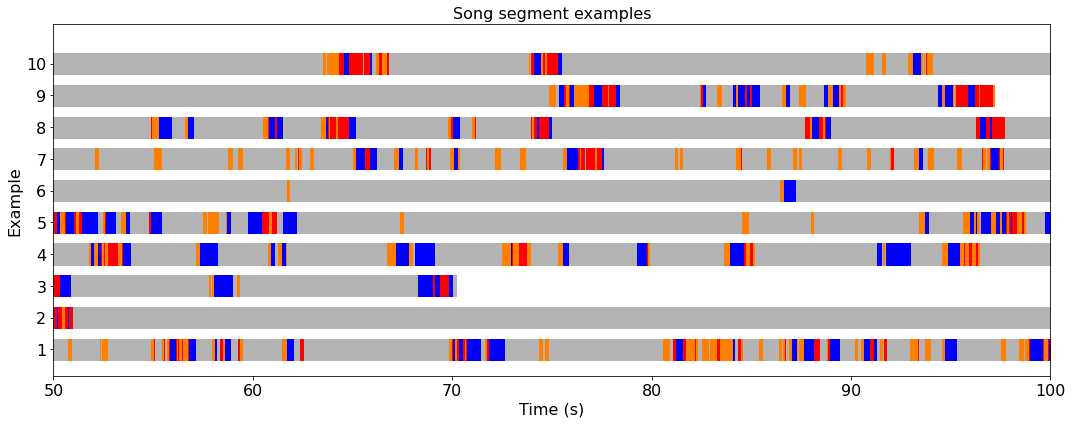

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6), tight_layout=True)

y_ticks = []
for cs, isong in enumerate(range(10)):
    s = songs[isong]
    t = np.arange(len(s))*dt
    plot_s(ax, t, s, extent=[0, len(s)*dt, 1.5*cs, 1.5*cs+1], c=COLORS, t_bar=0)
    y_ticks.append(1.5*cs + .5)

ax.set_xlim(50, 100)
ax.set_yticks(y_ticks)
ax.set_yticklabels(np.arange(len(y_ticks))+1)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Example')
ax.set_title('Song segment examples')

set_font_size(ax, 16)

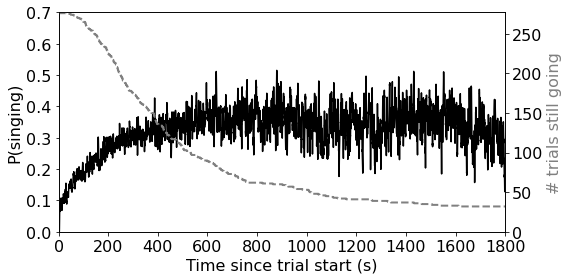

In [6]:
nt_max = np.max([len(s) for s in songs])

song_mat = -1 * np.ones((ntr, nt_max), dtype=int)
for cs, s in enumerate(songs):
    song_mat[cs, :len(s)] = s
    
ntr_vs_t = np.sum(song_mat >= 0, axis=0)
nsng_vs_t = np.sum(song_mat > 0, axis=0)
nsin_vs_t = np.sum(song_mat == 1, axis=0)
npsl_vs_t = np.sum(song_mat == 2, axis=0)
npfs_vs_t = np.sum(song_mat == 3, axis=0)

t = dt*np.arange(nt_max)

fig, ax = plt.subplots(1, 1, figsize=(8, 4), tight_layout=True)
ax.plot(t, mv_avg(t, nsng_vs_t/ntr_vs_t, 1), c='k', lw=1.5)
ax.set_ylim(0, .7)
ax.set_xlabel('Time since trial start (s)')
ax.set_ylabel('P(singing)')
ax2 = ax.twinx()
ax2.plot(t, ntr_vs_t, c='gray', lw=2, ls='--')
ax2.set_ylim(0, 277)
ax2.set_ylabel('# trials still going', color='gray')

ax.set_xlim(0, 1800)

set_font_size(np.array([ax, ax2]), 16)

# set_color(ax2, 'gray')

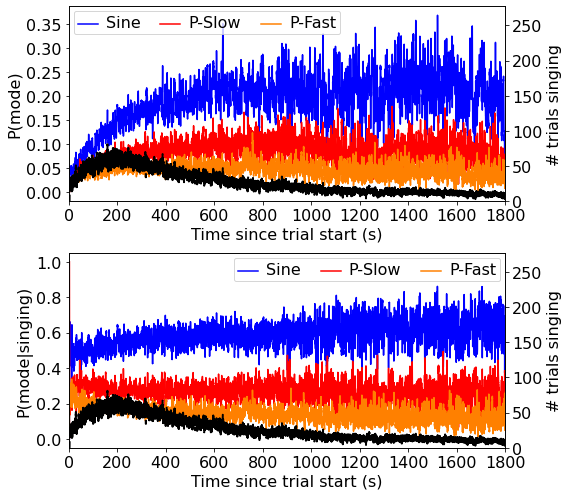

In [7]:
fig, axs = plt.subplots(2, 1, figsize=(8, 7), tight_layout=True)
axs[0].plot(t, mv_avg(t, nsin_vs_t/ntr_vs_t, 1), c='b', lw=1.5)
axs[0].plot(t, mv_avg(t, npsl_vs_t/ntr_vs_t, 1), c='r', lw=1.5)
axs[0].plot(t, mv_avg(t, npfs_vs_t/ntr_vs_t, 1), c=(1, .5, 0), lw=1.5)
axs[0].set_ylabel('P(mode)')

axs[1].plot(t, mv_avg(t, nsin_vs_t/nsng_vs_t, 1), c='b', lw=1.5)
axs[1].plot(t, mv_avg(t, npsl_vs_t/nsng_vs_t, 1), c='r', lw=1.5)
axs[1].plot(t, mv_avg(t, npfs_vs_t/nsng_vs_t, 1), c=(1, .5, 0), lw=1.5)
axs[1].set_ylabel('P(mode|singing)')

for ax in axs:
    ax.set_xlabel('Time since trial start (s)')
    ax.legend(['Sine', 'P-Slow', 'P-Fast'], ncol=3)
    ax.set_xlim(0, 1800)
    ax2 = ax.twinx()
    ax2.plot(t, nsng_vs_t, c='k', lw=2, ls='--')
    ax2.set_ylim(0, 277)
    ax2.set_ylabel('# trials singing')
    
    set_font_size(ax2, 16)
    
set_font_size(axs, 16)

## Autocorrelations for song segments beyond 600 s

Aggregated songs

In [8]:
songs_late = []
for s in songs:
    if len(s) > (660*fps):
        songs_late.append(s[int(round(600*fps)):])
songs_late = np.array(songs_late)

lag_bak = int(round(60*fps))
lag_fwd = int(round(60*fps))

t_cov = np.arange(-lag_bak, lag_fwd) * dt

/Users/rp21/opt/miniconda3/envs/sci/lib/python3.7/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """


Averaged across songs

In [9]:
# singing vs non-singing
covs_sng = []
for s in songs_late:
    sys.stdout.write('.')
    s_bnry = [(s > 0).astype(float)]
    cov_sng, _, _, _ = xcov_multi_with_confidence(s_bnry, s_bnry, lag_backward=lag_bak, lag_forward=lag_fwd, pre_norm=False, scale=True)
    covs_sng.append(cov_sng)

.............................................................................

In [10]:
covs_sng = np.array(covs_sng)
durs_late = dt*np.array([len(s) for s in songs_late])
dur_mat = np.tile(durs_late[:, None], (1, covs_sng.shape[1]))
dur_mat[np.isnan(covs_sng)] = np.nan
weight_mat = dur_mat / np.nansum(dur_mat, 0)

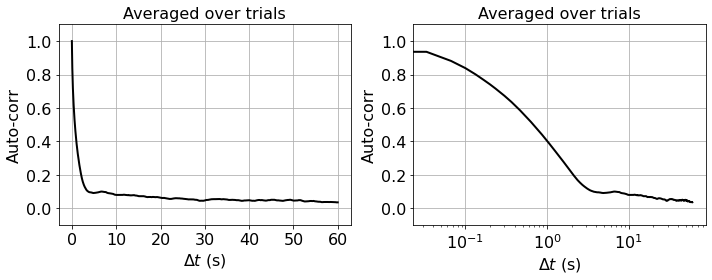

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)

covs_sng_mean = np.nansum(covs_sng*weight_mat, axis=0)

t_cov = np.arange(-lag_bak, lag_fwd) * dt

axs[0].plot(t_cov[t_cov >= 0], covs_sng_mean[t_cov >= 0], lw=2, c='k')
axs[1].semilogx(t_cov[t_cov >= 0], covs_sng_mean[t_cov >= 0], lw=2, c='k')

for ax in axs:
    ax.set_ylim(-.1, 1.1)
    ax.set_xlabel('$\Delta t$ (s)')
    ax.set_ylabel('Auto-corr')
    ax.set_title('Averaged over trials')
    ax.grid()
    
set_font_size(axs, 16)

In [12]:
# for each mode
covs = [[], [], [], []]

for s in songs_late:
    sys.stdout.write('.')
    for mode in range(4):
        s_bnry = [(s == mode).astype(float)]
        cov, _, _, _ = xcov_multi_with_confidence(
            s_bnry, s_bnry, lag_backward=lag_bak, lag_forward=lag_fwd, pre_norm=False, scale=True)
        
        covs[mode].append(cov)
        
cov_means = [np.nansum(weight_mat * np.array(covs_), axis=0) for covs_ in covs]

.............................................................................

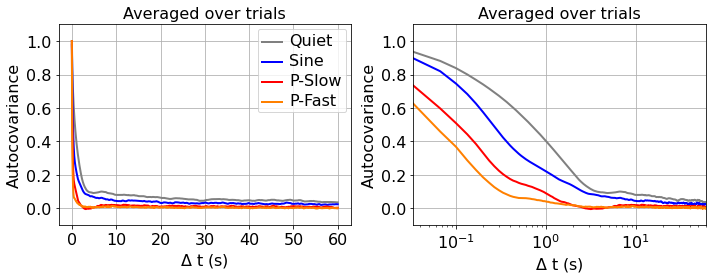

In [13]:
colors = ['gray', 'b', 'r', (1, .5, 0)]
labels = ['Quiet', 'Sine', 'P-Slow', 'P-Fast']
t_cov = np.arange(-lag_bak, lag_fwd) * dt

fig, axs = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)

for mode in [0, 1, 2, 3]:
    axs[0].plot(t_cov[t_cov >= 0], cov_means[mode][t_cov >= 0], lw=2, c=colors[mode])
    axs[1].semilogx(t_cov[t_cov > 0], cov_means[mode][t_cov > 0], lw=2, c=colors[mode])

axs[0].legend(labels)
axs[1].set_xlim(dt, lag_fwd*dt)
  
for ax in axs:
    ax.grid()
    ax.set_ylim(-.1, 1.1)
    ax.set_xlabel(r'$\Delta$ t (s)')
    ax.set_ylabel('Autocovariance')
    ax.set_title('Averaged over trials')

    set_font_size(ax, 16)